# Practice Session 03: Find near-duplicates using shingling

Author: <font color="white">Mario Muñoz Serrano</font>

Date: <font color="white">03/10/2022</font>

In [ ]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [ ]:
# Input file (Can be found in https://github.com/chatox/data-mining-course/blob/master/practicum/data/covid-lockdown-catalonia/CovidLockdownCatalonia.json.gz?raw=true)
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [ ]:
# Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union
def jaccard_similarity(array1, array2):

  set1 = set(array1)
  set2 = set(array2)

  union = set2.union(set1)
  intersection = set2.intersection(set1)

  empty = (len(union) == 0) & (len(intersection) == 0)

  if not empty:
    jaccard_index = len(intersection)/len(union)

    return jaccard_index
  
  return 0

In [ ]:
#code to test our function. Our tests cases should be:
#
#    Two arrays for which the jaccard similarity is 0.6666...
#    Two arrays for which the jaccard similarity is 0.75
#    Two arrays for which the jaccard similarity is 1.0
#    Two empty arrays should have jaccard similarity 0.0

def test_jaccard():
  a = [1, 2, 3, 4]
  b = [1, 2, 3, 5]
  c = [1, 2, 3]
  d = []

  pairs = [[a, a], [a, b], [b, c], [d,d]]

  for pair in pairs:
    print(f'For arrays a = {pair[0]} and b = {pair[1]} their jaccard similarity is: {jaccard_similarity(pair[0], pair[1])}')


test_jaccard()

For arrays a = [1, 2, 3, 4] and b = [1, 2, 3, 4] their jaccard similarity is: 1.0
For arrays a = [1, 2, 3, 4] and b = [1, 2, 3, 5] their jaccard similarity is: 0.6
For arrays a = [1, 2, 3, 5] and b = [1, 2, 3] their jaccard similarity is: 0.75
For arrays a = [] and b = [] their jaccard similarity is: 0


In [ ]:
#clean: cleans-up text according to this specification:
#
#    Removing "RT " prefixes
#    Converting to lowercase
#    Romanizing text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.
#    Removing URLs, both "http" and "https" ones.
#    Removing spaces at the beginning and spaces at the end with the strip() function.
#    Removing anything that remains that is not a letter or digit
#    Changing double spaces to single spaces.

def clean(string):

  if 'RT @' in string: 
    string = string.split('RT @')
    string = string[1]
  
  string = string.lower()

  string = re.sub('(https?://[^\s]+)', '', string)
  string = re.sub('https', '', string)
  string = re.sub('http', '', string)

  romanizing_mapping = [ [u'[áàâäãå]', 'a'], [u'[éèêë]', 'e'], [u'[íìîï]', 'i'], [u'[óòôöõ]', 'o'], [u'[úùûü]', 'u'], [u'[ñ]', 'n'], [u'[çčć]', 'c'], [u'[ýÿ]', 'y'] ]

  for mapping in romanizing_mapping:
    string = re.sub(mapping[0], mapping[1], string)

  string = re.sub(r'[^a-zA-Z0-9 ]', '', string)

  string = " ".join(string.split())
  
  return string.strip()

In [ ]:
# Test oour function by passing it five different texts including punctuation, non-Roman characters, URLs, etc. 

sample = [messages[i] for i in range(10)]
c = 1
for i in sample:
  print(f'TWEET {c}\n-NOT CLEANED:\n\t{i}\n-CLEANED:\n\t{clean(i)}\n-------------------------')
  c += 1

TWEET 1
-NOT CLEANED:
	RT @aramateix: La gestió del telèfon d'atenció 061 depèn de Ferrovial. La decisió del @govern NO modifica això. La gent no pagarà de manera…
-CLEANED:
	aramateix la gestio del telefon datencio 061 depen de ferrovial la decisio del govern no modifica aixo la gent no pagara de manera
-------------------------
TWEET 2
-NOT CLEANED:
	RT @Totbadalona: 🦠Els restaurants han de reduir el seu aforament en un 66% per garantir la seguretat davant del coronavirus #Badalona https…
-CLEANED:
	totbadalona els restaurants han de reduir el seu aforament en un 66 per garantir la seguretat davant del coronavirus badalona
-------------------------
TWEET 3
-NOT CLEANED:
	RT @XSalaimartin: Fa temps que sabem que aquest tal Garcia-Page és un miserable. Però amb això se supera fins i tot a sí mateix. https://t.…
-CLEANED:
	xsalaimartin fa temps que sabem que aquest tal garciapage es un miserable pero amb aixo se supera fins i tot a si mateix
-------------------------
TWEET 4
-NOT CLEANE

# 2. Implement an n-gram extractor

In [ ]:
# The only words you must consider in a ngram are words having at least MIN_TOKEN_LENGTH characters.

MIN_TOKEN_LENGTH = 2


# ngrams(text,size), which should produce all sub-sequences of size words present in the text
def ngrams(text, size):
    tokens = clean(text).split()

    # your code here
    tokens = [token for token in tokens if len(token) >= MIN_TOKEN_LENGTH]
    ngrams = [" ".join(tokens[i:i+size]) for i in range(len(tokens)-(size-1))]
      
    return ngrams

In [ ]:
# code testing function "ngrams"
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [ ]:
# computes the time it takes to compare all first limit messages against all first limit messages in the array.

# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

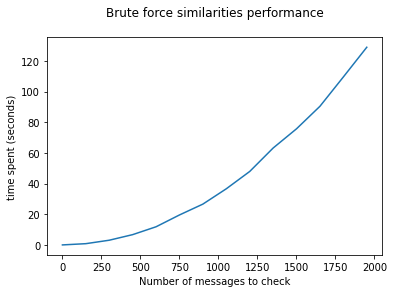

In [ ]:
# Use the function above to create a plot in which you have in the x axis the number of messages to check, 
# and in the y axis the time it takes to check that many messages if we use ngrams of size 3. 
# Try with x from 1 to 2001 in increments of 150 (use the range function).


m_num = []
time = []

for i in range(1, 2001, 150):
  m_num.append(i)
  time.append(time_brute_force_similarities(messages, i, 3))
    

plt.plot(m_num, time)
plt.title('Brute force similarities performance\n')
plt.xlabel('Number of messages to check')
plt.ylabel('time spent (seconds)')
plt.show()

In the plot we can see that the time runs exponentially as the number of messages grow. So the time it takes to check all the messages is.

- seconds: e^((log(20)/3)*40)
- minutes: (e^((log(20)/3)*40)) / 60
- hours: (e^((log(20)/3)*40)) / 60^2

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [ ]:
# Implement code to create:
# 
#     the dictionary ngram_to_index, which should convert an ngram to an index (a row number),
#     the dictionary index_to_ngram, which should convert an index to an ngram, and
#     the variable num_distinct_ngrams which should contain the number of distinct ngrams.

NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0
stored = set()


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)

    if len(clean(message).split()) > NGRAM_SIZE:
        for ngram in all_ngrams:
            
            if not ngram in stored:
              
              stored.add(ngram)
              ngram_to_index[ngram] = next_index
              index_to_ngram[next_index] = ngram
              next_index += 1


        

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 67013 distinct ngrams in the 10000 documents


In [ ]:
# Test your function by printing the ngram_to_index of the strings "tancat escoles fins" and "garantir la seguretat". 
# The exact index varies, depending on how you clean() text. Then, print the index_to_ngram of the returned index, 
# and should give you the same string.

strings = ['tancat escoles fins', 'garantir la seguretat']

for string in strings:
  index = ngram_to_index[string]

  print(f"The index of {string} is: {ngram_to_index[string]}")
  print(f"The ngram in index {index} is: {index_to_ngram[index]}")
  print('--')

The index of tancat escoles fins is: 938
The ngram in index 938 is: tancat escoles fins
--
The index of garantir la seguretat is: 34
The ngram in index 34 is: garantir la seguretat
--


## 4.2 Create table ngrams x documents

In [ ]:
# The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents 
# you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, 
# and then try again.


# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 67013 rows (distinct shingles) x 10000 columns (distinct documents)


In [ ]:
# Complete the matrix M_ngram_doc so that position i, j (row, column) holds a True if document j contains ngram i, otherwise holds False

for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    if len(clean(message).split()) > NGRAM_SIZE:
        for ngram in all_ngrams:
            # replace this comment with your code
            
            index = ngram_to_index[ngram]
            M_ngram_doc[index][docid] = True

In [ ]:
# Measure the density of this matrix, as a percentage. 
# This is the number of non-zeroes in the matrix as a percentage of the number of cells of the matrix.
print(f'The density of the matrix is {round((M_ngram_doc.sum()/M_ngram_doc.size)*100, 3)}%')

The density of the matrix is 0.023%


In [ ]:
# printing rows 9602 and 941 of the M_ngram_doc matrix

docids = [9602, 941]

for docid in docids:
    print(f'Positions of non-zeros in column of docid {docid} of M_ngram_doc\n')
    print(f'Clean message:\n  {clean(messages[docid])}\n')
    print('Non-zeros in corresponding row:\n')
    ngr = [f'{i} ({index_to_ngram[i]})' for i in range(num_distinct_ngrams) if M_ngram_doc[i][docid] == True]
    print(ngr)
    print('\n-------------------------------------\n')

Positions of non-zeros in column of docid 9602 of M_ngram_doc

Clean message:
  emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio

Non-zeros in corresponding row:

['910 (si us plau)', '1221 (emergenciescat que puc)', '1222 (que puc fer)', '1223 (puc fer que)', '1224 (fer que no)', '2573 (14 de marc)', '39115 (que no faqs)', '39116 (no faqs del)', '39117 (faqs del coronavirus)', '39118 (del coronavirus 14)', '39119 (coronavirus 14 de)', '39120 (de marc si)', '39121 (marc si us)', '39122 (us plau demanem)', '39123 (plau demanem difusio)']

-------------------------------------

Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean message:
  hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general

Non-zeros in corresponding row:

['1474 (usem de forma)', '1475 (de forma responsable)', '1476 (forma responsable els)', '1477 (responsable els recursos)', '1478 (els 

# 5. Implement a permutation generator

In [ ]:
# Implement the function random_permutation(k), which should generate a random permutation of the array [0, 2, 3, ..., k-1]
def random_permutation(k):
  return list(np.random.permutation(k))


In [ ]:
# Further test this by applying the same permutation on two lists. The code below, which you must leave as-is, 
# should print both lists in the same ordering, so that alpha is in the same position of a, beta in the same 
# position as b, and so on.



# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (ek)", "2 (do)", "3 (tīn)", "4 (chār)", "5 (pāṅc)"]
original_list_2 = ["1 (jedan)", "2 (dva)", "3 (tri)", "4 (četiri)", "5 (pet)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['2 (do)', '3 (tīn)', '5 (pāṅc)', '4 (chār)', '1 (ek)']
['2 (dva)', '3 (tri)', '5 (pet)', '4 (četiri)', '1 (jedan)']

Test another permutation
['2 (do)', '3 (tīn)', '5 (pāṅc)', '4 (chār)', '1 (ek)']
['2 (dva)', '3 (tri)', '5 (pet)', '4 (četiri)', '1 (jedan)']


# 6. Compute the signature of each document

In [ ]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 49833, 52572, 36935, ...
Permutation 1: 373, 33965, 18267, ...
Permutation 2: 5271, 56791, 47800, ...
Permutation 3: 31377, 23835, 2861, ...
Permutation 4: 57832, 14634, 65821, ...


In [ ]:
# Now, you implement the signature construction. The matrix M_signature_doc should contain in row i, column j, 
# the first ngram (the "minimum" one) that is present in a column (document), according to the order given 
# by a permutation.
# This process may take a few minutes to be completed.



M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
        M_signature_doc[permutation_num][docid] = find_first_one(docid, permutation)

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [ ]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [61, 3332, 3458, 4102, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921]
Signature     : [4917.0, 4912.0, 3332.0, 4908.0, 4909.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio 

# 7. Compare all pairs of signatures

In [ ]:
# code for comparing all signatures; print all documents that have at least 50 signature matches, considering both full matches and partial matches.

is_possible_duplicate = {}

thereshold = 50
documents_thereshold = 0

selected = {'difference': -500, 'docid': 0, 'full_matches': 0, 'partial_matches': 0}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # REPLACE THIS COMMENT WITH YOUR CODE:
                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed
                jaccard_sim = jaccard_similarity(signature1, signature2)

                if jaccard_sim > 0.2  and  jaccard_sim <= 1:

                  if jaccard_sim == 1: count_sig_full_matches += 1
                  else: count_sig_partial_matches += 1

                  is_possible_duplicate[docid1]= docid2


        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        
        if count_sig_full_matches + count_sig_partial_matches > thereshold:
          print(f'Document with id {docid1} has {count_sig_full_matches} full and {count_sig_partial_matches} partial matches')
          documents_thereshold += 1
          m = count_sig_full_matches - count_sig_partial_matches
          if m > selected['difference']:
            selected['difference'] = m
            selected['docid'] = docid1
            selected['full_matches'] = count_sig_full_matches
            selected['partial_matches'] = count_sig_partial_matches


0/10000 documents scanned
Document with id 16 has 71 full and 18 partial matches
Document with id 42 has 18 full and 34 partial matches
Document with id 53 has 57 full and 0 partial matches
Document with id 83 has 63 full and 0 partial matches
Document with id 84 has 70 full and 18 partial matches
Document with id 85 has 27 full and 24 partial matches
Document with id 166 has 56 full and 0 partial matches
Document with id 167 has 55 full and 0 partial matches
Document with id 168 has 54 full and 0 partial matches
Document with id 172 has 53 full and 0 partial matches
Document with id 174 has 52 full and 0 partial matches
Document with id 176 has 51 full and 0 partial matches
Document with id 192 has 62 full and 0 partial matches
Document with id 221 has 61 full and 0 partial matches
Document with id 280 has 60 full and 0 partial matches
Document with id 307 has 17 full and 70 partial matches
Document with id 328 has 65 full and 0 partial matches
Document with id 331 has 64 full and 0 p

In [ ]:
print(f'In total {documents_thereshold} documents have at least {thereshold} signature matches, considering both full matches and partial matches.')

In total 294 documents have at least 50 signature matches, considering both full matches and partial matches.


Below we can see the tweet with largest difference between full matches and partial matches. I think that the reason why this tweet is not being changed is because it comes from an official chanel, it has important information about covid in times where the information was limited (14 march) and the tweet itself request difusion.

In [ ]:
print(f'The tweet with largest difference between full matches and partial matches is:\n{messages[selected["docid"]]}\n\n With:\n\t- {selected["full_matches"]} full matches\n\t- {selected["partial_matches"]} partial matches')

The tweet with largest difference between full matches and partial matches is:
RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK

 With:
	- 176 full matches
	- 3 partial matches
